# Implementação DQN no ambiente Swift com manipulador panda.

Replay buffer <br>
DNN para representar o agente atual e uma DNN alvo com uma taxa de atualização menor.

In [7]:
import torch
import pickle
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
from scipy.signal import convolve, gaussian
import os
import io
import base64
import time
import glob
from IPython.display import HTML
from DQN_panda_utils import DQNAgent, evaluate, ReplayBuffer,\
        compute_td_loss,play_and_record, smoothen, epsilon_schedule,\
                generate_animation, display_animation
from panda_env import Panda_RL
                
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

#j3 range -0.08 a 3.75  #j2 range -0.07 a -3. #j1 range -1.8 a 1.76

In [8]:
torch.cuda.is_available()

False

### Sistema observável e com medidas dos ângulos disponíveis


    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Joint1                   -4.8                    4.8
        1       Joint2                    -Inf                    Inf
        2       Joint3                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        
    Actions:
        Type: Discrete(9)
        Num   Three actions for each joint
        0     decrement joint j
        1     increment joint j
        2     decrement join  j

        #j3 range 0.0 a 3.7
        #j2 range 0.0 a -3.
        #j1 range -1.7 a 1.7


        



In [9]:
# self.panda = rp.models.Panda()
# self.panda_end = rp.models.Panda()
# self.m=100 #magnification factor

# self.obstacle = Cuboid([0.2, 0.2, 0.8], pose=sm.SE3(0.3, 0, 0)) 
# #self.floor = Cuboid([0.2, 0.2, 0.8], pose=sm.SE3(-0.2, 0, 0)) 
# self.obs_floor = Cuboid([2., 2., 0.01], pose=sm.SE3(0, 0, 0), color=[100,100,100,0])#"black") #color=[100,100,100,0]
# self.scene.add(self.obs_floor)
# self.scene.add(self.obstacle)
# self.scene.add(self.panda, robot_alpha=0.6)
# self.delta=delta
# #End joints positions
# j=[0.8,-1.5,1] 
# self.q_end=[0., j[0], 0.,j[1], 0., j[2], 0.]
# self.Tep = self.panda.fkine(self.q_end)

In [10]:
state_shape = 3
env=Panda_RL()
agent=DQNAgent(state_shape, epsilon=0).to(device)
env.delta=0.02
RESTORE_AGENT=True # Restore a trained agent
NEW_BUFFER=True # Restore a buffer
TRAIN=True # Train or only simulate
env.renderize=True #stop robot viewing

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 38500)
Traceback (most recent call last):
  File "/home/taniel/anaconda3/envs/RTB/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/taniel/anaconda3/envs/RTB/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/home/taniel/anaconda3/envs/RTB/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/taniel/anaconda3/envs/RTB/lib/python3.10/site-packages/swift/SwiftRoute.py", line 221, in __init__
    super(MyHttpRequestHandler, self).__init__(
  File "/home/taniel/anaconda3/envs/RTB/lib/python3.10/http/server.py", line 658, in __init__
    super().__init__(*args, **kwargs)
  File "/home/taniel/anaconda3/envs/RTB/lib/python3.10/socketserver.py", line 747, in

In [11]:
if RESTORE_AGENT:
    percentage_of_total_steps=0.1
    agent.load_state_dict(torch.load('model_panda_trained.pth'))
    with open('td_loss_history.pickle', 'rb') as handle:
        td_loss_history=pickle.load(handle)
    with open('mean_rw_history.pickle', 'rb') as handle:
        mean_rw_history=pickle.load(handle)
else:
    percentage_of_total_steps=0.9
    mean_rw_history = []
    td_loss_history = []

env.panda

ERobot: panda (by Franka Emika), 7 joints (RRRRRRR), 1 gripper, geometry, collision
┌─────┬──────────────┬───────┬─────────────┬────────────────────────────────────────────────┐
│link │     link     │ joint │   parent    │              ETS: parent to link               │
├─────┼──────────────┼───────┼─────────────┼────────────────────────────────────────────────┤
│   0 │ panda_link0  │       │ BASE        │                                                │
│   1 │ panda_link1  │     0 │ panda_link0 │ SE3(0, 0, 0.333) ⊕ Rz(q0)                      │
│   2 │ panda_link2  │     1 │ panda_link1 │ SE3(-90°, -0°, 0°) ⊕ Rz(q1)                    │
│   3 │ panda_link3  │     2 │ panda_link2 │ SE3(0, -0.316, 0; 90°, -0°, 0°) ⊕ Rz(q2)       │
│   4 │ panda_link4  │     3 │ panda_link3 │ SE3(0.0825, 0, 0; 90°, -0°, 0°) ⊕ Rz(q3)       │
│   5 │ panda_link5  │     4 │ panda_link4 │ SE3(-0.0825, 0.384, 0; -90°, -0°, 0°) ⊕ Rz(q4) │
│   6 │ panda_link6  │     5 │ panda_link5 │ SE3(90°, -0°, 0°) ⊕ Rz(q5

In [12]:
target_network = DQNAgent(agent.state_shape, epsilon=0.5).to(device)
#Copying weights from agent network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [13]:
env.panda.q=env.panda.qz
# set a seed
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)




In [14]:
q_far=np.array([ 0., -0.8 ,  0. , -0.0698,  0.,  3.3825,  0.    ])
env.panda.q=q_far
env.scene.step()
print(env.distance(),env.fitness())


4.342661864180592 10.28177829


In [15]:
env.panda.q=env.panda.qz
env.scene.step()
print(env.distance(),env.fitness())

1.6138186274239739 3.68547204


In [16]:
env.panda.q=env.q_goal
env.scene.step()
print(env.distance(),env.fitness())
T_end=env.panda.fkine(env.q_goal)
T_end

0.6141983869955122 0.0


   0.1892    0.1892   -0.9636    0.4463    
   0.7071   -0.7071    0         0         
  -0.6813   -0.6813   -0.2675    0.1586    
   0         0         0         1         


In [17]:
print(agent.network)

Sequential(
  (layer1): Linear(in_features=3, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (relu2): ReLU()
  (layer4): Linear(in_features=256, out_features=26, bias=True)
)


### Main loop



In [18]:
# Fill buffer with samples collected ramdomly from environment
buffer_len=1000
tmax=300
env.renderize=False
if NEW_BUFFER:
    exp_replay = ReplayBuffer(buffer_len)
    #Add Expert user experience
    q_far=np.array([ 0., -0.8 ,  0. , -0.0698,  0.,  3.3825,  0.    ])
    env.panda.q=q_far
    env.scene.step()
    for i in range(94):
        a=[0,-1,0]
        s=env.get_q()
        pos,r,done,info=env.step(a)
        exp_replay.add(s, a, r, pos, done)
        print(pos,r,env.fitness())
    for i in range(60):
        a=[1,0,0]
        s=env.get_q()
        pos,r,done,info=env.step(a)
        exp_replay.add(s, a, r, pos, done)
        print(pos,r,env.fitness())
    for i in range(88):
        a=[0,0,-1]
        s=env.get_q()
        pos,r,done,info=env.step(a)
        exp_replay.add(s, a, r, pos, done)
        print(pos,r,env.fitness())

[-0.8    -0.0898  3.3825] -157.06958338579005 10.22497029
[-0.8    -0.1098  3.3825] 155.94302298524505 10.16896229
[-0.8    -0.1298  3.3825] 155.92655421741415 10.11375429
[-0.8    -0.1498  3.3825] 155.9096012106255 10.05934629
[-0.8    -0.1698  3.3825] 155.89214228976132 10.00573829
[-0.8    -0.1898  3.3825] 155.87415446656772 9.952930290000001
[-0.8    -0.2098  3.3825] 155.8556133386899 9.90092229
[-0.8    -0.2298  3.3825] 155.83649297924484 9.84971429
[-0.8    -0.2498  3.3825] 155.81676581588383 9.79930629
[-0.8    -0.2698  3.3825] 155.79640249815708 9.74969829
[-0.8    -0.2898  3.3825] 155.7753717518387 9.70089029
[-0.8    -0.3098  3.3825] 155.75364021869365 9.65288229
[-0.8    -0.3298  3.3825] 155.73117227995795 9.60567429
[-0.8    -0.3498  3.3825] 155.70792986156928 9.55926629
[-0.8    -0.3698  3.3825] 155.68387221890873 9.51365829
[-0.8    -0.3898  3.3825] 155.6589556984926 9.468850289999999
[-0.8    -0.4098  3.3825] 155.63313347368387 9.42484229
[-0.8    -0.4298  3.3825] 155.60

/home/taniel/anaconda3/envs/RTB/lib/python3.10/site-packages/roboticstoolbox/robot/Link.py:1041: FutureWarning: base kwarg is deprecated, use pose instead
  warn("base kwarg is deprecated, use pose instead", FutureWarning)
pybullet build time: Jul 21 2022 19:48:53


In [19]:
# Fill buffer with samples collected ramdomly from environment
buffer_len=5000
# exp_replay = ReplayBuffer(buffer_len)
env.renderize=False

if NEW_BUFFER:
    
    for i in range(50):
        
        state=env.reset()
        # Play 100 runs of experience with 100 steps and  stop if reach 10**4 samples
        play_and_record(state, agent, env, exp_replay, n_steps=60)
        
        if len(exp_replay) == buffer_len:
            break
    print(len(exp_replay))



    with open('buffer.pickle', 'wb') as handle:
        pickle.dump(exp_replay.buffer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    exp_replay = ReplayBuffer(buffer_len)
    with open('buffer.pickle', 'rb') as handle:
        exp_replay.buffer=pickle.load(handle)



1000


In [20]:

env.renderize=False
percentage_of_total_steps=0.01

In [22]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 64
total_steps = 15 * 10**3
#total_steps = 10

#init Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-3)

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = percentage_of_total_steps*total_steps

# setup some frequency for logging and updating target network
loss_freq = 40
refresh_target_network_freq = 100
eval_freq = 500

# to clip the gradients
max_grad_norm = 5000

buffer size = 1000, epsilon = 0.05000
Frequency evaluation = 500


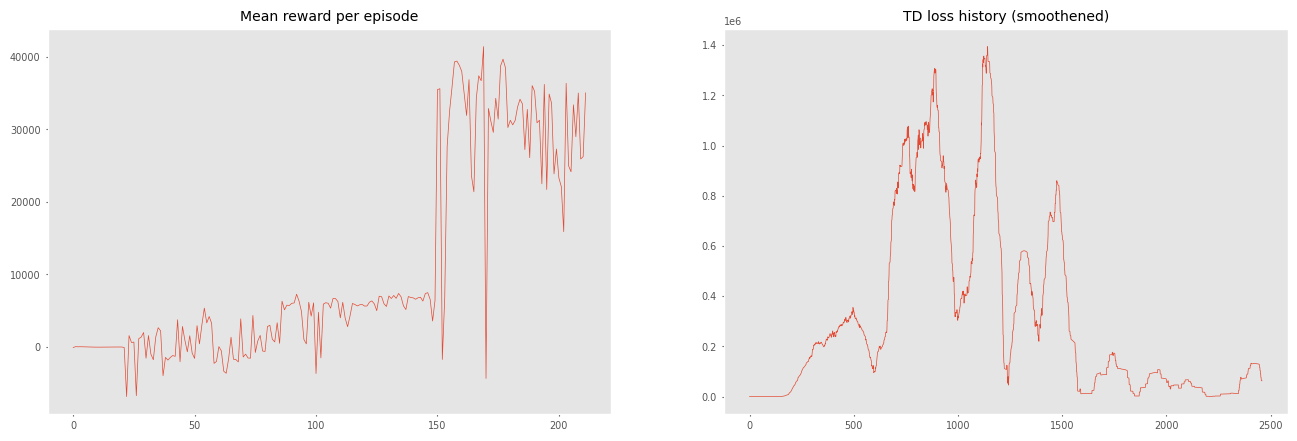

100%|██████████| 15001/15001 [05:20<00:00, 46.79it/s] 


In [24]:
if TRAIN:
    state = env.reset()
    for step in trange(total_steps + 1):
        
        
        # reduce exploration as we progress
        agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

        # take timesteps_per_epoch and update experience replay buffer
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train by sampling batch_size of data from experience replay
        states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
        actions =[agent.get_action_index(i) for i in actions]
        

        # loss = <compute TD loss>
        loss = compute_td_loss(agent, target_network, 
                            states, actions, rewards, next_states, done_flags,                  
                            gamma=0.99,
                            device=device)

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())

        if step % eval_freq == 0:
            # eval the agent
            mean_rw_history.append(evaluate(env, agent, n_games=40, greedy=True, t_max=tmax)[0] )

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))
            print(f"Frequency evaluation = {eval_freq}")

            plt.figure(figsize=[16, 5])
            plt.subplot(1, 2, 1)
            plt.title("Mean reward per episode")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(1, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(smoothen(td_loss_history))
            plt.grid()
            plt.show()

In [27]:
env.renderize=True
final_score,m_steps,infos = evaluate(env,agent, n_games=1, greedy=True, t_max=500)
print(f'final score:{final_score} in {m_steps} steps')
print(infos)
print(f'Well done , Distance: {env.distance()}')
print(f"collision {env.detect_collision()[0]}")

final score:57929.97191442539 in 499.0 steps
[['', '']]
Well done , Distance: 0.69174504964347
collision False


In [26]:
SAVE_AGENT=False
SAVE_AGENT=True

FILE_PREFIX=['mean_rw_history','td_loss_history']
EXTENSION='.pickle'
NAME="-reduced_network"
FILENAME=[]
for i in FILE_PREFIX:
    FILENAME.append(i+NAME+EXTENSION)


if SAVE_AGENT:
    torch.save(agent.state_dict(), 'model_panda_trained.pth')
    for (i,j) in zip(FILENAME,FILE_PREFIX):
        with open(i, 'wb') as handle:
            pickle.dump(j, handle, protocol=pickle.HIGHEST_PROTOCOL)
   

In [21]:
state = env.reset()
qvalues = agent.get_qvalues([state])
action = agent.actions_space[qvalues.argmax(axis=-1)[0]]
state, r, done, info = env.step(action)
print(state, r, done, info)

[ 0.47 -1.46  1.93] -0.31434354714937784 False ['', '']


In [22]:
qvalues = agent.get_qvalues([state])
action = agent.actions_space[qvalues.argmax(axis=-1)[0]]
state, r, done, _ = env.step(action)

In [23]:
state = env.reset()
reward = 0
while True:
    qvalues = agent.get_qvalues([state])
    action = agent.actions_space[qvalues.argmax(axis=-1)[0]]
    state, r, done, info = env.step(action)
    reward += r
    #print(reward)
    if done or reward < -60:
        print('Got reward: {}'.format(reward))
        break
print(f'Done , Distance: {env.distance()}')
print(f"collision {env.detect_collision()[0]}")
print(info)

Got reward: -60.23543929349693
Done , Distance: 0.11567246589957013
collision False
['', '']


In [24]:
state=env.get_q()
qvalues = agent.get_qvalues([state])
qvalues

array([[37.720524, 37.62541 , 37.7483  , 37.662205, 37.581844, 37.723557,
        37.18852 , 37.282505, 37.045635, 37.559494, 37.64467 , 37.614708,
        37.549328, 37.694244, 37.145237, 37.227955, 37.039345, 36.688076,
        36.48168 , 37.024166, 36.7472  , 37.522846, 37.011032, 36.137203,
        36.146122, 36.124207]], dtype=float32)

In [25]:
len(a)

3

**Let us record a video of trained agent**

In [26]:
# # Animate learned policy
# save_dir='./videos/'
# #env = make_env(env_name)
# generate_animation(env, agent, save_dir=save_dir)
# [filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))

# display_animation(filepath)

In [27]:
#TODO

# Run this on another environment in OpenAI Gym
# Create a robotic environment with more actions
#